# Нейросетевые модели поиска. Часть II. Переранжирование.
## Домашнее задание

В этом задании вам предстоит обучить модели переранжирования с архитектурой cross-encoder и bi-encoder на датасете [VK MARCO](https://cloud.mail.ru/public/MQ3H/GVGeAWZoj). За его решение можно получить до 10 баллов, а также еще 10 бонусных за выполнение дополнительных заданий.

**Вам надо:**

- Форкнуть эту репу;
- Создать бранч, в котором вы дальше будете работать;
- Выполнить все или часть заданий ноутбука;
- Запушить ваш бранч и поставить Pull Request.

Проверяющий счекаутит вашу бранчу и проверит работу.

**Замечания:**

- При выполнении задания можете использовать код из соответствующего семинара;
- Вам предстоит сделать как минимум 2 обучения (а при выполнении дополнительных заданий и того больше), постарайтесь переиспользовать код и минимизировать копипасты;
- Старайтесь писать чистый и понятный код, не оставляйте в ноутбуке лишний мусор (выводы ячеек с pip install, ненужный закомментированный код и т.д.);
- При сдаче дз сохраните выходы ячеек с логами обучения и графиками. Если для построения графиков вы использовали tensorboard, то вставьте графики в ноутбук в виде скриншотов;
- Итоговый ноутбук должен быть работоспособен, то есть проверяющий должен иметь возможность запустить все его ячейки в том порядке, в котором они распологаются в ноутбуке, и получить результаты, аналогичные вашим.


### Данные [1 балл]

Скачайте и распакуйте датасет [VK MARCO](https://cloud.mail.ru/public/MQ3H/GVGeAWZoj). Архив содержит следующие файлы (формат аналогичен MS MARCO):
* vkmarco-docs.tsv - tsv с текстами документов;
* vkmarco-doctrain-queries.tsv - tsv с текстами запросов;
* vkmarco-doctrain-qrels.tsv - tsv с оценками релевантности запроса и документа;
* Аналогичный набор файлов для валидации.

Загрузите данные трейна и валидации в pandas.DataFrame так, чтобы он содержал следующие колонки:
* qid - id запроса;
* query - текст запроса;
* text - текст документа;
* label - оценка релевантности запроса и документа.

In [1]:
prefix = '' #'/kaggle/input/vk-marko/'  директория, где лежит датасет

import pandas as pd
texts = pd.read_csv(prefix + 'vkmarco-docs.tsv', sep='	', names=['docid', 'url', 'title', 'text'])
texts.head()

,docid,url,title,text
0,D000000001,zvuk.top/tracks/%D0%B4%D0%BE%D0%BC-raim-feat-a...,Дом raim feat artur adil музыка в MP3 🎵 – скач...,Скачивай и слушай 🎧 raim дом o2 2018 на Zvuk.t...
1,D000000002,musickz.kz/index.php?newsid=3221,Скачать RaiM feat. Artur & Adil - Дом 2018,Скачать песню RaiM feat. Artur & Adil - Дом бе...
2,D000000003,muzvuk.net/1965-raim-ft-artur-amp-adil-dom.html,RaiM ft. Artur & Adil - Дом - Скачать mp3,Скачать песню RaiM ft. Artur & Adil - Дом в Фо...
3,D000000004,zvuq.net/4415-raim-feat-artur-adil-dom.html,RaiM feat. Artur & Adil - Дом - скачать в mp3 ...,Скачать RaiM feat. Artur & Adil - Дом в mp3 фо...
4,D000000005,mussic.kz/kazahskie-pesni/2417-raim-feat-artur...,Скачать Дом - RaiM feat. Artur & Adil — Mussic.kz,Здесь можете бесплатно скачать Дом - RaiM feat...


In [2]:
q_texts = pd.read_csv(prefix + 'vkmarco-doctrain-queries.tsv', sep='\t', names=['qid', 'query'])
q_texts.head()

,qid,query
0,1857,акватекс электромаш в москве умывальник
1,23006,верно или верно имя прилагательное
2,1621,xramvoskresenka ru исмаилиты
3,13951,скачать текст песни юта сильные люди
4,9939,ооо производственно монтажный трест 96 7727844313


In [3]:
q_rels = pd.read_csv(prefix + 'vkmarco-doctrain-qrels.tsv', sep=' ', names=['qid', 'what_is_it', 'docid', 'label'])
q_rels.head()

,qid,what_is_it,docid,label
0,1,0,D000000001,1
1,1,0,D000000002,3
2,1,0,D000000003,2
3,1,0,D000000004,2
4,1,0,D000000005,2


In [4]:
first_merge = pd.merge(q_rels, q_texts, on='qid')
second_merge = pd.merge(first_merge, texts, on='docid')[['qid', 'query', 'text', 'label']]
train_data = second_merge # данные трейна
second_merge.head()

,qid,query,text,label
0,1,0 00 дом muzono net raim feat artur adil скачать,Скачивай и слушай 🎧 raim дом o2 2018 на Zvuk.t...,1
1,1,0 00 дом muzono net raim feat artur adil скачать,Скачать песню RaiM feat. Artur & Adil - Дом бе...,3
2,1,0 00 дом muzono net raim feat artur adil скачать,Скачать песню RaiM ft. Artur & Adil - Дом в Фо...,2
3,1,0 00 дом muzono net raim feat artur adil скачать,Скачать RaiM feat. Artur & Adil - Дом в mp3 фо...,2
4,1,0 00 дом muzono net raim feat artur adil скачать,Здесь можете бесплатно скачать Дом - RaiM feat...,2


Аналогичным образом получим валидацию:

In [5]:
texts_val = texts
texts_val.head()

,docid,url,title,text
0,D000000001,zvuk.top/tracks/%D0%B4%D0%BE%D0%BC-raim-feat-a...,Дом raim feat artur adil музыка в MP3 🎵 – скач...,Скачивай и слушай 🎧 raim дом o2 2018 на Zvuk.t...
1,D000000002,musickz.kz/index.php?newsid=3221,Скачать RaiM feat. Artur & Adil - Дом 2018,Скачать песню RaiM feat. Artur & Adil - Дом бе...
2,D000000003,muzvuk.net/1965-raim-ft-artur-amp-adil-dom.html,RaiM ft. Artur & Adil - Дом - Скачать mp3,Скачать песню RaiM ft. Artur & Adil - Дом в Фо...
3,D000000004,zvuq.net/4415-raim-feat-artur-adil-dom.html,RaiM feat. Artur & Adil - Дом - скачать в mp3 ...,Скачать RaiM feat. Artur & Adil - Дом в mp3 фо...
4,D000000005,mussic.kz/kazahskie-pesni/2417-raim-feat-artur...,Скачать Дом - RaiM feat. Artur & Adil — Mussic.kz,Здесь можете бесплатно скачать Дом - RaiM feat...


In [6]:
q_texts_val = pd.read_csv(prefix + 'vkmarco-docdev-queries.tsv', sep='\t', names=['qid', 'query'])
q_texts_val.head()

,qid,query
0,30334,гос аптеки в уфе адреса телефоны
1,21704,имя аллаха азиз перевод
2,31818,подружка дорама
3,14856,стоимость плитки бетонной 40 40
4,31101,купать квартиру на апанасенковской


In [7]:
q_rels_val = pd.read_csv(prefix + 'vkmarco-docdev-qrels.tsv', sep=' ', names=['qid', 'what_is_it', 'docid', 'label'])
q_rels_val.head()

,qid,what_is_it,docid,label
0,5,0,D000000067,2
1,5,0,D000000068,2
2,5,0,D000000069,2
3,5,0,D000000070,1
4,5,0,D000000071,1


In [8]:
first_merge = pd.merge(q_rels_val, q_texts_val, on='qid')
first_merge.head()

,qid,what_is_it,docid,label,query
0,5,0,D000000067,2,05 05 2019 выходной
1,5,0,D000000068,2,05 05 2019 выходной
2,5,0,D000000069,2,05 05 2019 выходной
3,5,0,D000000070,1,05 05 2019 выходной
4,5,0,D000000071,1,05 05 2019 выходной


In [9]:
second_merge = pd.merge(first_merge, texts_val, on='docid')[['qid', 'query', 'text', 'label']]
val_data = second_merge # данные валидации
second_merge.head()

,qid,query,text,label
0,5,05 05 2019 выходной,"Выходные, праздники, не рабочие дни в 2019 год...",2
1,5,05 05 2019 выходной,Официальные праздники и выходные в мае 2019 го...,2
2,5,05 05 2019 выходной,null Как отдыхают в мае 2019 года в России и с...,2
3,5,05 05 2019 выходной,"О рабочем времени в 2022 году 📅: выходные, пра...",1
4,5,05 05 2019 выходной,В мае 2019 года у украинцев будут дополнительн...,1


In [10]:
# пытаемся разгрузить оперативную память
del q_texts
del texts
del q_rels
del first_merge
del texts_val

### Baselines \[2 балла\]

Реализуйте подсчет метрик MRR@k и NDCG@k. Посчитайте их значения на валидационном сете для нескольких бейзлайнов:
1. Модель, делающая случайное предсказание;
1. BM25.

Отнормируем разметку в наших датасетах:

In [11]:
train_data['label'] /= max(train_data['label'])
val_data['label'] /= max(val_data['label'])

In [12]:
val_data = val_data.sort_values(by="qid").reset_index(drop=True)
train_data = train_data.sort_values(by="qid").reset_index(drop=True)

In [13]:
train_data['label'].unique()

array([0.33333333, 0.66666667, 1.        , 0.        ])

In [13]:
import torch
from torchmetrics.retrieval import RetrievalMRR
from torchmetrics.retrieval import RetrievalNormalizedDCG

def MRR(preds, target, qids, k=10):
    mrr = RetrievalMRR(top_k=k)

    return mrr(torch.Tensor(preds), 
               torch.Tensor(target), 
               indexes=torch.LongTensor(qids - min(qids)))

def NDCG(preds, target, qids, k=10):
    ndcg = RetrievalNormalizedDCG(top_k=k)
    return ndcg(torch.Tensor(preds),
               torch.Tensor(target),
               indexes=torch.LongTensor(qids - min(qids)))

d:\python\anaconda3\envs\cd\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Случайное предсказание

In [15]:
import numpy as np
from rank_bm25 import BM25Okapi
import tqdm

In [16]:
rand_result = np.random.random(len(val_data))

for k in (5, 10, 15, 20):
    mrr = MRR(rand_result, val_data['label'].values == 1, val_data['qid'].values, k)
    ndcg = NDCG(rand_result, val_data['label'].values, val_data['qid'].values, k)
    print(f"MRR@{k}: {mrr}, NDCG@{k}: {ndcg}")


MRR@5: 0.20200000703334808, NDCG@5: 0.6284500956535339
MRR@10: 0.22053857147693634, NDCG@10: 0.6860967874526978
MRR@15: 0.22649745643138885, NDCG@15: 0.7350507974624634
MRR@20: 0.22924552857875824, NDCG@20: 0.7773889899253845


## BM25

In [17]:
corpus = val_data['text'].values
tokenized_corpus = [doc.split(" ") for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

In [18]:
def get_bm25_scores(data, bm25):
    queries = data['query'].unique()
    bm25_preds = np.zeros(len(data))
    for q in tqdm.tqdm(queries):
        tokenized_query = q.split(" ")
        doc_scores = bm25.get_scores(tokenized_query)
        mask = data['query'] == q
        bm25_preds[mask] = doc_scores[mask]
    return bm25_preds

bm25_preds = get_bm25_scores(val_data, bm25)
bm25_preds

100%|██████████| 5000/5000 [1:46:30<00:00,  1.28s/it]  


array([14.25359517,  4.84542921, 12.76122411, ...,  0.        ,
        0.        ,  0.        ])

In [19]:
for k in (5, 10, 15, 20):
    mrr = MRR(bm25_preds, val_data['label'].values == 1, val_data['qid'].values, k)
    ndcg = NDCG(bm25_preds, val_data['label'].values, val_data['qid'].values, k)
    print(f"MRR@{k}: {mrr}, NDCG@{k}: {ndcg}")

MRR@5: 0.21346333622932434, NDCG@5: 0.6361457705497742
MRR@10: 0.23201943933963776, NDCG@10: 0.6947138905525208
MRR@15: 0.2375270575284958, NDCG@15: 0.7435205578804016
MRR@20: 0.24023081362247467, NDCG@20: 0.7849999070167542


### Обучение cross-encoder \[2 балла\]

Выполните следующие задания:
* Обучите модель xlm-roberta-base в фомате cross-encoder.
* Постройте графики зависимости метрик от количества пройденных шагов.
* Посчитайте метрики для финальной модели.
* Сколько времени заняло обучение?

In [14]:
import torch
import transformers
from torch import nn
from torch.utils import data
from torch.utils.data import Dataset
import numpy as np
from transformers import AutoTokenizer, AutoModel, XLMRobertaTokenizer, XLMRobertaTokenizer
from sklearn.metrics import roc_auc_score
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter


In [15]:
class RankBert_cross(nn.Module):
    def __init__(self, train_layers_count=2):
        super(RankBert_cross, self).__init__()

        self.bert = AutoModel.from_pretrained("xlm-roberta-base")
        self.config = self.bert.config

        # freeze all layers without bias and LN
        for name, par in self.bert.named_parameters():
            if 'bias' in name or 'LayerNorm' in name:
                continue
            par.requires_grad = False

        layer_count = self.config.num_hidden_layers
        for i in range(train_layers_count): #unfreeze somw layers
            for par in self.bert.encoder.layer[layer_count - 1 - i].parameters():
                par.requires_grad = True
        
        # map cls token emb to relevance score
        self.head = nn.Linear(self.config.hidden_size, 1) 
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None):
        x = self.bert(input_ids=input_ids,
                      token_type_ids=token_type_ids,
                      attention_mask=attention_mask
                      )[0][:, 0, :] #hidden_state of [CLS]
        x = self.head(x)
        return x




class RankDataset_cross(Dataset):
    def __init__(self, data, neg_p=1.0):
        self.neg_p = neg_p
        self.data = data
        self.tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
        
    def __getitem__(self, index):
        query, text, label = self.data.iloc[index, [1, 2, 3]]
        tokens = self.tokenizer(query, text, padding='max_length', truncation=True, max_length=64, return_tensors='pt')
        tokens['input_ids'] = tokens['input_ids'].view(64)
        return tokens, torch.tensor(label).view(-1)

    def __len__(self):
        return len(self.data)

In [16]:
dataset_train = RankDataset_cross(train_data)
dataset_valid = RankDataset_cross(val_data)

In [17]:
train_dataloader = data.DataLoader(dataset_train, shuffle=True, batch_size=256, num_workers=2)
valid_dataloader = data.DataLoader(dataset_valid, shuffle=False, batch_size=128)

In [18]:
model = RankBert_cross(train_layers_count=0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cuda', index=0)

In [31]:
!mkdir cross_encоder_checkpoint

In [19]:
class config:
    EPOCHS=1
    LR=1e-4
    WD=0.01
    SAVE_DIR="cross_encоder_checkpoint"
    SAVE_INTERVAL=1000
    BATCH_SIZE=256
    ACCUM_BS=1
    DEVICE=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    LOG_INTERVAL=250

writer = SummaryWriter('cross_encоder_checkpoint/')

loss_fn = nn.BCEWithLogitsLoss()

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LR, weight_decay=config.WD)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                pct_start=0.1,
                                                max_lr=config.LR,
                                                epochs=config.EPOCHS, 
                                                steps_per_epoch=len(train_dataloader))

In [21]:
from tqdm.notebook import tqdm as tqdm_note
import gc

In [22]:
def move_batch_to_device(batch, device):
    batch_x, y = batch
    for key in batch_x:
        batch_x[key] = batch_x[key].to(device)
    y = y.to(device)
    return batch_x, y

Оперативной памяти ноутбука Kaggle не хватает на полноценное обучение модели, поэтому остановимся только на первых 1500 шагах:

In [36]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    running_auc = 0.
    last_loss = 0.

    device = config.DEVICE
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, batch in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        batch_x, y = move_batch_to_device(batch, device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(**batch_x)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, y)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        scheduler.step()

        # Gather data and report
        running_loss += loss.item()

        y = y.cpu().int().numpy()
        if y.sum() > 0:
            #compute metric
            with torch.no_grad():
                auc = roc_auc_score(y, 
                                    outputs.cpu().numpy(), 
                                    labels=np.array([0, 1]))
            running_auc += np.mean(auc)
        else:
            running_auc += 1
        
        #logging to tb
        tb_x = epoch_index * len(train_dataloader) + i + 1
        tb_writer.add_scalar('lr', scheduler.get_last_lr()[0], tb_x)
        tb_writer.add_scalar('Train/auc', auc, tb_x)
        tb_writer.add_scalar('Train/loss', loss, tb_x)
        
        if i % config.LOG_INTERVAL == config.LOG_INTERVAL - 1:
            last_loss = running_loss / config.LOG_INTERVAL # loss per batch
            last_auc = running_auc / config.LOG_INTERVAL # loss per batch
            print('  batch {} loss: {}, auc: {}'.format(i + 1, last_loss, last_auc))
            
            tb_writer.add_scalar('Train/running_loss', last_loss, tb_x)
            tb_writer.add_scalar('Train/running_auc', last_auc, tb_x)
            running_loss = 0.
            running_auc = 0.
        if i + 1 >= 1500:
            break # на бОльшее число не хватает оперативной памяти kaggle ноутбука
        if i % 10 == 0: #clean up memory
            gc.collect()
            torch.cuda.empty_cache()

    return last_loss, last_auc

In [37]:
epoch_number = 0

best_vloss = 1_000_000.

for epoch in range(config.EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, avg_auc = train_one_epoch(epoch_number, writer)
    
    running_vloss = 0.0
    running_vauc = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        preds = []
        for i, batch in enumerate(valid_dataloader):
            batch_x, y = move_batch_to_device(batch, config.DEVICE)
            voutputs = model(**batch_x)
            vloss = loss_fn(voutputs, y)
            running_vloss += vloss

            y = y.cpu().int().numpy()
            if y.sum() > 0:
                #compute metric
                with torch.no_grad():
                    auc = roc_auc_score(y, 
                                        voutputs.cpu().numpy(), 
                                        labels=np.array([0, 1]))
                running_vauc += np.mean(auc)
            else:
                running_vauc += 1


    avg_vloss = running_vloss / (i + 1)
    avg_vauc = running_vauc / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print('AUC train {} valid {}'.format(avg_auc, avg_vauc))
    writer.add_scalar('Valid/loss', avg_vloss, epoch)
    writer.add_scalar('Valid/auc', avg_vauc, epoch)
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss

        checkpoint = {'epoch': epoch, 'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'scheduler_state_dict': scheduler.state_dict(),
                      'best_vloss': best_vloss}

        torch.save(checkpoint, f'{config.SAVE_DIR}/ckpt_epoch_{epoch}_loss{best_vloss}.pt')

    epoch_number += 1

EPOCH 1:
  batch 250 loss: 0.699835932731745, auc: 0.5282185318823093
  batch 500 loss: 0.6899345278667991, auc: 0.5910007579366034
  batch 750 loss: 0.685852810727556, auc: 0.6233087682214432
  batch 1000 loss: 0.683520768810786, auc: 0.6434937949484492
  batch 1250 loss: 0.6823084031316904, auc: 0.6519787186001595
  batch 1500 loss: 0.6808078263737478, auc: 0.6684999697607562
LOSS train 0.6808078263737478 valid 0.6790188419793486
AUC train 0.6684999697607562 valid 0.6629572523010059


In [ ]:
torch.save(model, 'model_cross.pth')

In [23]:
model = torch.load('model_cross.pth')

In [28]:
import time
import tqdm
start_time = time.time()
def get_test_perds(model):
    model.eval() #eval mode
    y_test = []

    for i, batch in enumerate(tqdm.tqdm(valid_dataloader, position=0, leave=True, desc=f"Iteration: {'test'}")): #итерируемся по батчам
        batch_x, y = move_batch_to_device(batch, config.DEVICE)
        with torch.no_grad():
            preds = model(**batch_x)
            y_test += [preds]

    y_test = torch.cat(y_test).view(-1).cpu().numpy()
    return y_test

y_test = get_test_perds(model)
end_time = time.time()
print(f"Время выполнения на валидации: {end_time - start_time} секунд")

Iteration: test: 100%|██████████| 1199/1199 [48:54<00:00,  2.45s/it] 


Время выполнения на валидации: 2934.50394654274 секунд


In [29]:
print(roc_auc_score(dataset_valid.data['label'].values == 1, y_test, labels=np.array([0, 1])))

0.6971788700655901


In [30]:
for k in (5, 10, 15, 20):
    mrr = MRR(y_test, val_data['label'].values == 1, val_data['qid'].values, k)
    ndcg = NDCG(y_test, val_data['label'].values, val_data['qid'].values, k)
    print(f"MRR@{k}: {mrr}, NDCG@{k}: {ndcg}")

MRR@5: 0.2682066857814789, NDCG@5: 0.6744014620780945
MRR@10: 0.2836635112762451, NDCG@10: 0.7252538204193115
MRR@15: 0.2881871163845062, NDCG@15: 0.7680648565292358
MRR@20: 0.29031798243522644, NDCG@20: 0.8052927255630493


Модель обучалась почти 52 минуты:

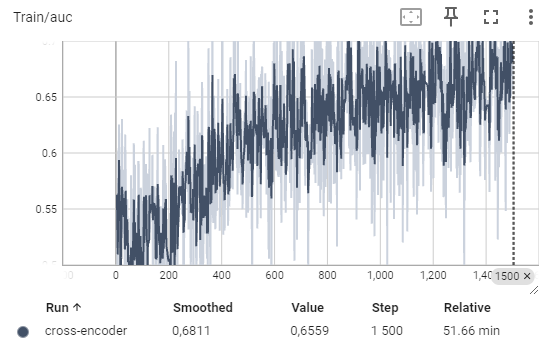
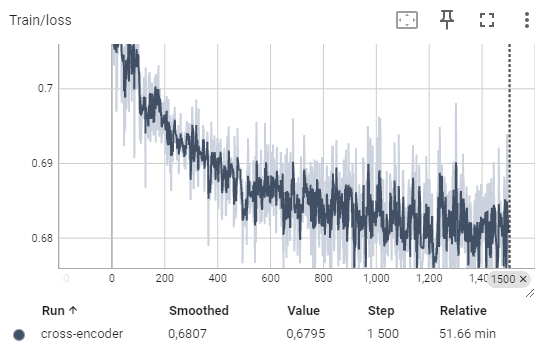

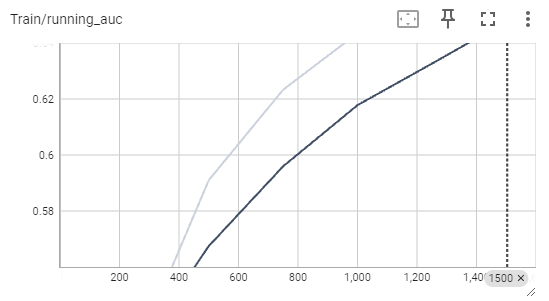
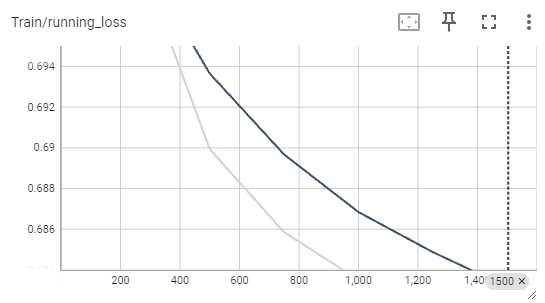


### Обучение bi-encoder \[4 балла\]

Вспомним, что разница между cross-encoder и bi-encoder моделями заключается способе получения скора релевантности:

| Cross-encoder | Bi-encoder |
| - | - |
| 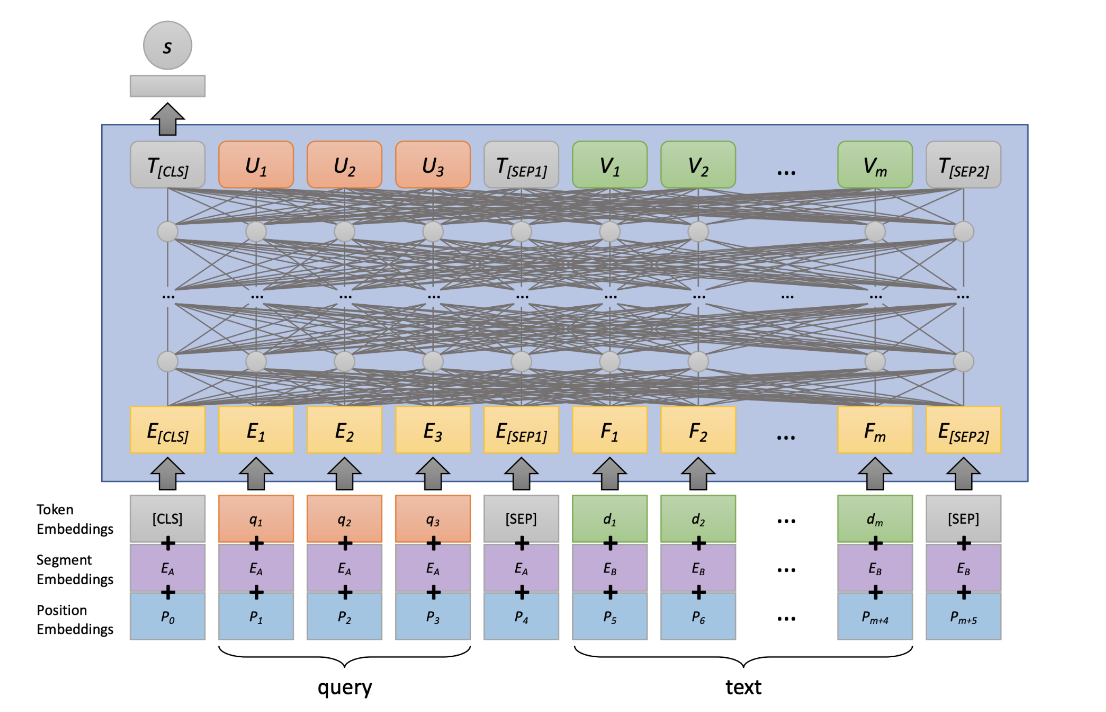 | 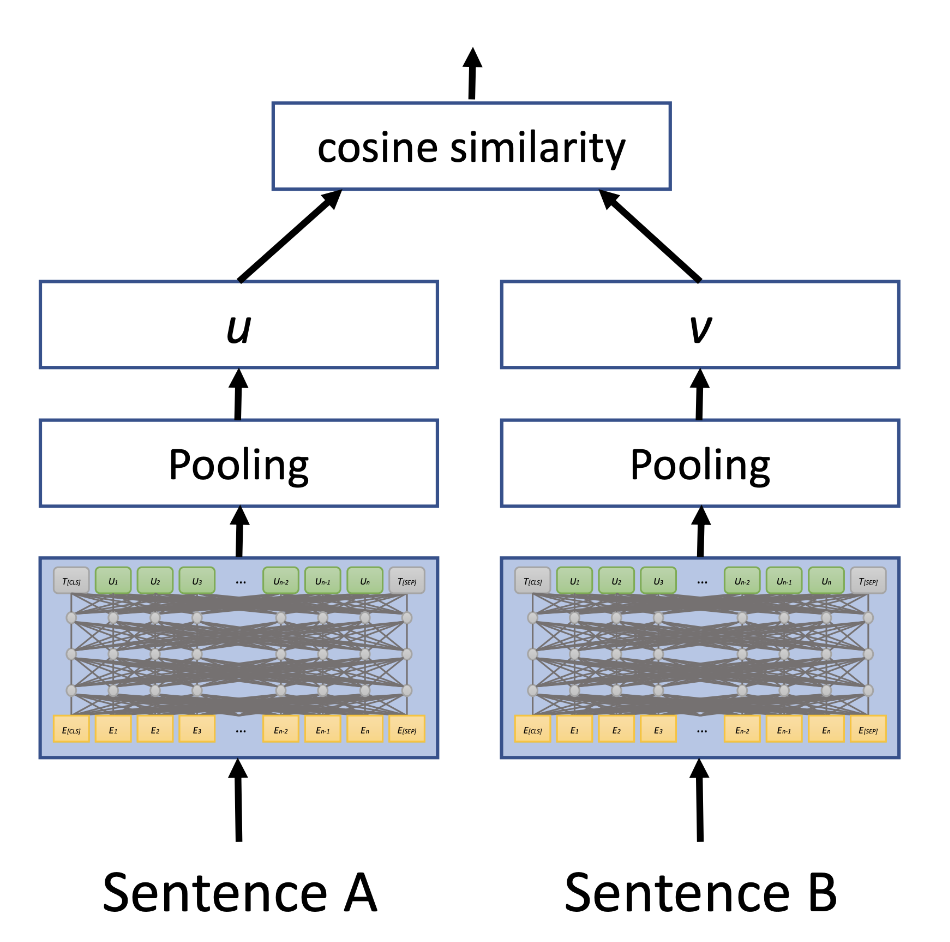 |

Выполните следующие задания:
* Внесите необходимые изменения в код и обучите xlm-roberta-base в фомате bi-encoder.
* Постройте графики зависимости метрик от количества пройденных шагов.
* Посчитайте метрики для финальной модели.
* Сколько времени заняло обучение?

In [21]:
class RankBert_bi(nn.Module):
    def __init__(self, emb_size=64, train_layers_count=2):
        super(RankBert_bi, self).__init__()

        self.bert = AutoModel.from_pretrained("xlm-roberta-base")
        self.config = self.bert.config

        # freeze all layers without bias and LN
        for name, par in self.bert.named_parameters():
            if 'bias' in name or 'LayerNorm' in name:
                continue
            par.requires_grad = False

        layer_count = self.config.num_hidden_layers
        for i in range(train_layers_count): #unfreeze somw layers
            for par in self.bert.encoder.layer[layer_count - 1 - i].parameters():
                par.requires_grad = True
        
        # map cls token emb to relevance score
        self.head = nn.Linear(self.config.hidden_size, emb_size) 
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None):
        x = self.bert(input_ids=input_ids,
                      token_type_ids=token_type_ids,
                      attention_mask=attention_mask
                      )[0][:, 0, :] #hidden_state of [CLS]
        x = self.head(x)
        return x




class RankDataset_bi(Dataset):
    def __init__(self, data, neg_p=1.0):
        self.neg_p = neg_p
        self.data = data
        self.tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
        
    def __getitem__(self, index):
        query, text, label = self.data.iloc[index, [1, 2, 3]]
        q = self.tokenizer(query, padding='max_length', truncation=True, max_length=64, return_tensors='pt')
        t = self.tokenizer(text, padding='max_length', truncation=True, max_length=64, return_tensors='pt')
        q['input_ids'] = q['input_ids'].view(64)
        t['input_ids'] = t['input_ids'].view(64)
        return q, t, torch.tensor(label).view(-1)

    def __len__(self):
        return len(self.data)

In [22]:
dataset_train = RankDataset_bi(train_data)
dataset_valid = RankDataset_bi(val_data)
train_dataloader = data.DataLoader(dataset_train, shuffle=True, batch_size=128, num_workers=2, drop_last=True)
valid_dataloader = data.DataLoader(dataset_valid, shuffle=False, batch_size=128, drop_last=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [23]:
model = RankBert_bi(train_layers_count=0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
device

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

device(type='cuda', index=0)

In [24]:
class config:
    EPOCHS=1
    LR=1e-4
    WD=0.01
    SAVE_DIR="bi_encоder_checkpoint"
    SAVE_INTERVAL=1000
    BATCH_SIZE=128
    ACCUM_BS=1
    DEVICE=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    LOG_INTERVAL=250

writer = SummaryWriter('bi_encоder_checkpoint/')

loss_fn = nn.BCEWithLogitsLoss()

In [25]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LR, weight_decay=config.WD)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                pct_start=0.1,
                                                max_lr=config.LR,
                                                epochs=config.EPOCHS, 
                                                steps_per_epoch=len(train_dataloader))

In [26]:
def move_batch_to_device_bi(batch, device):
    batch_q, batch_t, y = batch
    for key in batch_q:
        batch_q[key] = batch_q[key].to(device)
    for key in batch_t:
        batch_t[key] = batch_t[key].to(device)
    y = y.to(device)
    return batch_q, batch_t, y

In [27]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    running_auc = 0.
    last_loss = 0.

    device = config.DEVICE
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, batch in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        batch_q, batch_t, y = move_batch_to_device_bi(batch, device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = (model(**batch_q)*model(**batch_t)).sum(-1)

        # Compute the loss and its gradients
        loss = loss_fn(outputs.view(128), y.view(128))
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        scheduler.step()

        # Gather data and report
        running_loss += loss.item()

        y = y.cpu().int().numpy()
        if y.sum() > 0:
            #compute metric
            with torch.no_grad():
                auc = roc_auc_score(y, 
                                    outputs.cpu().numpy(), 
                                    labels=np.array([0, 1]))
            running_auc += np.mean(auc)
        else:
            running_auc += 1
        
        #logging to tb
        tb_x = epoch_index * len(train_dataloader) + i + 1
        tb_writer.add_scalar('lr', scheduler.get_last_lr()[0], tb_x)
        tb_writer.add_scalar('Train/auc', auc, tb_x)
        tb_writer.add_scalar('Train/loss', loss, tb_x)
        
        if i % config.LOG_INTERVAL == config.LOG_INTERVAL - 1:
            last_loss = running_loss / config.LOG_INTERVAL # loss per batch
            last_auc = running_auc / config.LOG_INTERVAL # loss per batch
            print('  batch {} loss: {}, auc: {}'.format(i + 1, last_loss, last_auc))
            
            tb_writer.add_scalar('Train/running_loss', last_loss, tb_x)
            tb_writer.add_scalar('Train/running_auc', last_auc, tb_x)
            running_loss = 0.
            running_auc = 0.
        if i + 1 >= 1500:
            break # на бОльшее число не хватает оперативной памяти kaggle
        
        if i % 10 == 0: #clean up memory
            gc.collect()
            torch.cuda.empty_cache()

    return last_loss, last_auc

In [28]:
epoch_number = 0

best_vloss = 1_000_000.

for epoch in range(config.EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, avg_auc = train_one_epoch(epoch_number, writer)
    
    running_vloss = 0.0
    running_vauc = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        preds = []
        for i, batch in enumerate(valid_dataloader):
            batch_q, batch_t, y = move_batch_to_device_bi(batch, config.DEVICE)
            voutputs = (model(**batch_q)*model(**batch_t)).sum(-1)
            vloss = loss_fn(voutputs.view(128), y.view(128))
            running_vloss += vloss

            y = y.cpu().int().numpy()
            if y.sum() > 0:
                #compute metric
                with torch.no_grad():
                    auc = roc_auc_score(y, 
                                        voutputs.cpu().numpy(), 
                                        labels=np.array([0, 1]))
                running_vauc += np.mean(auc)
            else:
                running_vauc += 1


    avg_vloss = running_vloss / (i + 1)
    avg_vauc = running_vauc / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print('AUC train {} valid {}'.format(avg_auc, avg_vauc))
    writer.add_scalar('Valid/loss', avg_vloss, epoch)
    writer.add_scalar('Valid/auc', avg_vauc, epoch)
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss

        checkpoint = {'epoch': epoch, 'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'scheduler_state_dict': scheduler.state_dict(),
                      'best_vloss': best_vloss}

        torch.save(checkpoint, f'{config.SAVE_DIR}/ckpt_epoch_{epoch}_loss{best_vloss}.pt')

    epoch_number += 1

EPOCH 1:
  batch 250 loss: 3.141294167845198, auc: 0.4955437909900603
  batch 500 loss: 1.0518470951957317, auc: 0.5077175127126176
  batch 750 loss: 0.777849287207545, auc: 0.5093431696665216
  batch 1000 loss: 0.7242718446601357, auc: 0.5172743068226937
  batch 1250 loss: 0.7097896186085173, auc: 0.5211281556852567
  batch 1500 loss: 0.7026944835748726, auc: 0.5300992875189967
LOSS train 0.7026944835748726 valid 0.6943324442008173
AUC train 0.5300992875189967 valid 0.5653154027152689


In [31]:
def get_test_perds(model):
    model.eval() #eval mode
    y_test = []

    for i, batch in enumerate(tqdm.tqdm(valid_dataloader, position=0, leave=True, desc=f"Iteration: {'test'}")): #итерируемся по батчам
        batch_q, batch_t, y = move_batch_to_device_bi(batch, config.DEVICE)
        with torch.no_grad():
            preds = (model(**batch_q)*model(**batch_t)).sum(-1)
            y_test += [preds]

    y_test = torch.cat(y_test).view(-1).cpu().numpy()
    return y_test

y_test = get_test_perds(model)

Время выполнения на валидации: 2083.49780205 секунд


In [32]:
print(roc_auc_score((dataset_valid.data['label'].values == 1)[:len(y_test)], y_test, labels=np.array([0, 1])))

0.5713595058137446


In [35]:
for k in (5, 10, 15, 20):
    mrr = MRR(y_test, (dataset_valid.data['label'].values == 1)[:len(y_test)], val_data['qid'].values[:len(y_test)], k)
    ndcg = NDCG(y_test, dataset_valid.data['label'].values[:len(y_test)], val_data['qid'].values[:len(y_test)], k)
    print(f"MRR@{k}: {mrr}, NDCG@{k}: {ndcg}")

MRR@5: 0.22062334418296814, NDCG@5: 0.6377614140510559
MRR@10: 0.2377912849187851, NDCG@10: 0.6942445635795593
MRR@15: 0.24330830574035645, NDCG@15: 0.7430602312088013
MRR@20: 0.24587637186050415, NDCG@20: 0.7838624119758606


Обучение би-энкодера заняло примерно 28 минут:

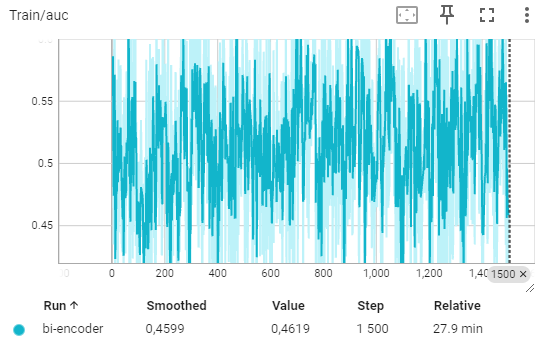
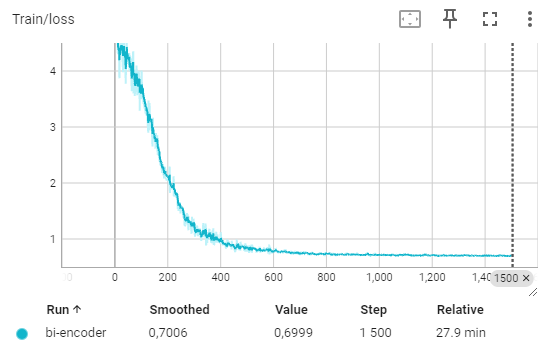

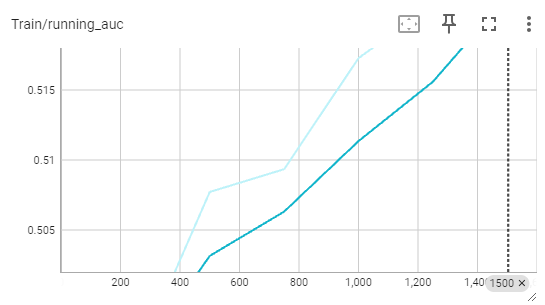
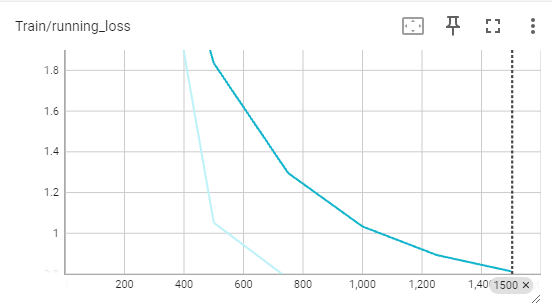

### Сравнение cross-encoder и bi-encoder архитектур \[2 балла\]

Выполните следующие задания:
* Сравните графики обучения моделей, скорость обучения и скорость инфернса.
* Напишите вывод.

Наложим графики друг на друга:

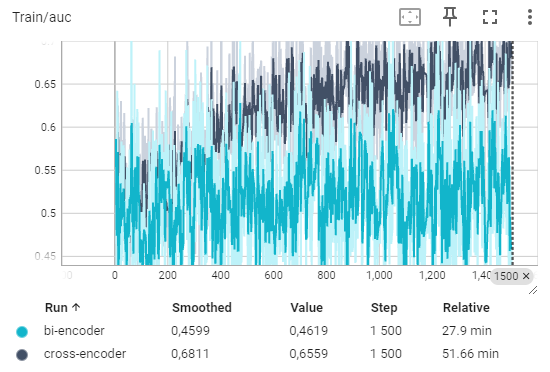
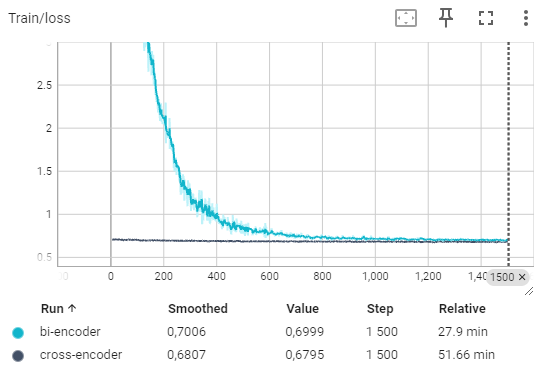

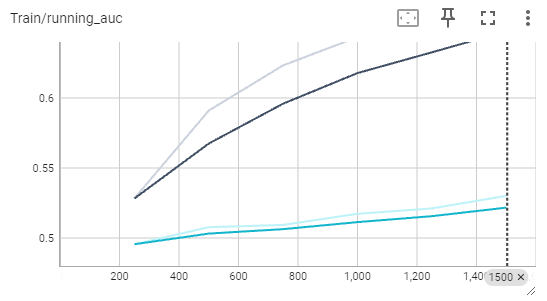
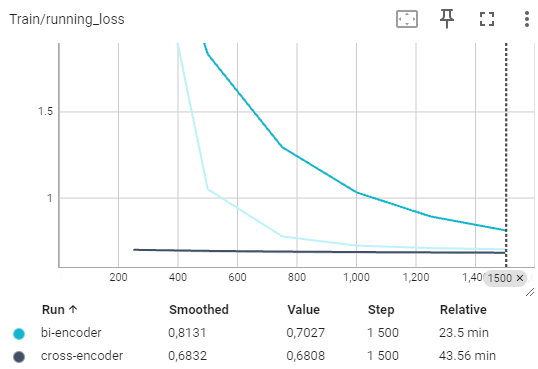

Кросс-энкодер показывает значительно более лучшее качество, если сравнивать с би-энкодером, но при этом требует бОльшего времени на обучение и инференс.

### Дополнительно \[10 баллов\]

Вы можете получить дополнительные баллы, выполнив одно или несколько заданий:
* Обучите cross-encoder в fp16 с использованием AMP, посчитайте метрики, есть ли изменения? **[1 балла]**
* Реализуйте семплирование примеров с учетом их длинны, насколько ускорилось обучение cross-encoder? **[1 балла]**
* Попробуйте увеличить метрики bi-encoder за счет использования другого претрейна. Кроме xlm-roberta-base на [Huggingface](https://huggingface.co/models) есть большое количество предобученных моделей BERT. Датасет содержит тексты на русском языке, поэтому стоит обратить внимание на русскоязычные или мультиязычные претрейны. Если вам удасться улучшить метрику, то предположите, какие отличия претрейна на это повлияли. **[2 балла]**
* Попробуйте разморозить больше параметров модели (например, последний трансформерный слой). Как изменилось качество и скорость обучения? **[2 балла]**
* Попробуйте использовать listwise лосс для обучения модели, как изменились метрики? **[4 балла]**

In [ ]:
# YOUR CODE HERE